In [1]:
import sys
sys.path.append("../")

from rbm import fasta_read, get_beta_and_W, all_weights, RBM
import analysis_methods as am

from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import subprocess as sp
import matplotlib.image as mpimg

In [2]:
# Directory of Stored RBMs
mdir = "/mnt/D1/globus/cov_trained_rbms/"
rounds = [f"r{i}" for i in range(1, 13)]

#### Generate Weights

In [ ]:
# generate weights in respective
for rid, round in enumerate(rounds[1:]):
    # if rid > 0:
    #     break
    checkp, version_dir = am.get_checkpoint_path(round, rbmdir=mdir)
    tmp = RBM.load_from_checkpoint(checkp)
    all_weights(tmp, version_dir +round+"_weights", 5, 1, 6, 2, "dna")

In [3]:
def assign(x):
    if x < 10:
        return "L" # low
    elif x < 50:
        return "M" # medium
    else:
        return "H" # High

# Stores all data in a dictionary ("data")
all_data = am.fetch_data(rounds, dir="../../cov", assignment_function=assign, threads=12)

Process Time 11.810589075088501
Process Time 5.844568967819214
Process Time 0.41689181327819824
Process Time 0.3384852409362793
Process Time 1.4100475311279297
Process Time 0.9790494441986084
Process Time 1.6722838878631592
Process Time 0.5754868984222412
Process Time 0.1706218719482422
Process Time 0.4281015396118164
Process Time 0.188704252243042
Process Time 0.41945767402648926


In [5]:
# Generate Sequence Logo for Each round
paths_u, paths_w = [], []
for r in rounds:
    paths_u.append(am.seq_logo(all_data[all_data["round"] == r], f"{r}_seqlogo", weight=False, outdir="./generated/"))
    paths_w.append(am.seq_logo(all_data[all_data["round"] == r], f"{r}_w_seqlogo", weight=True, outdir="./generated/"))

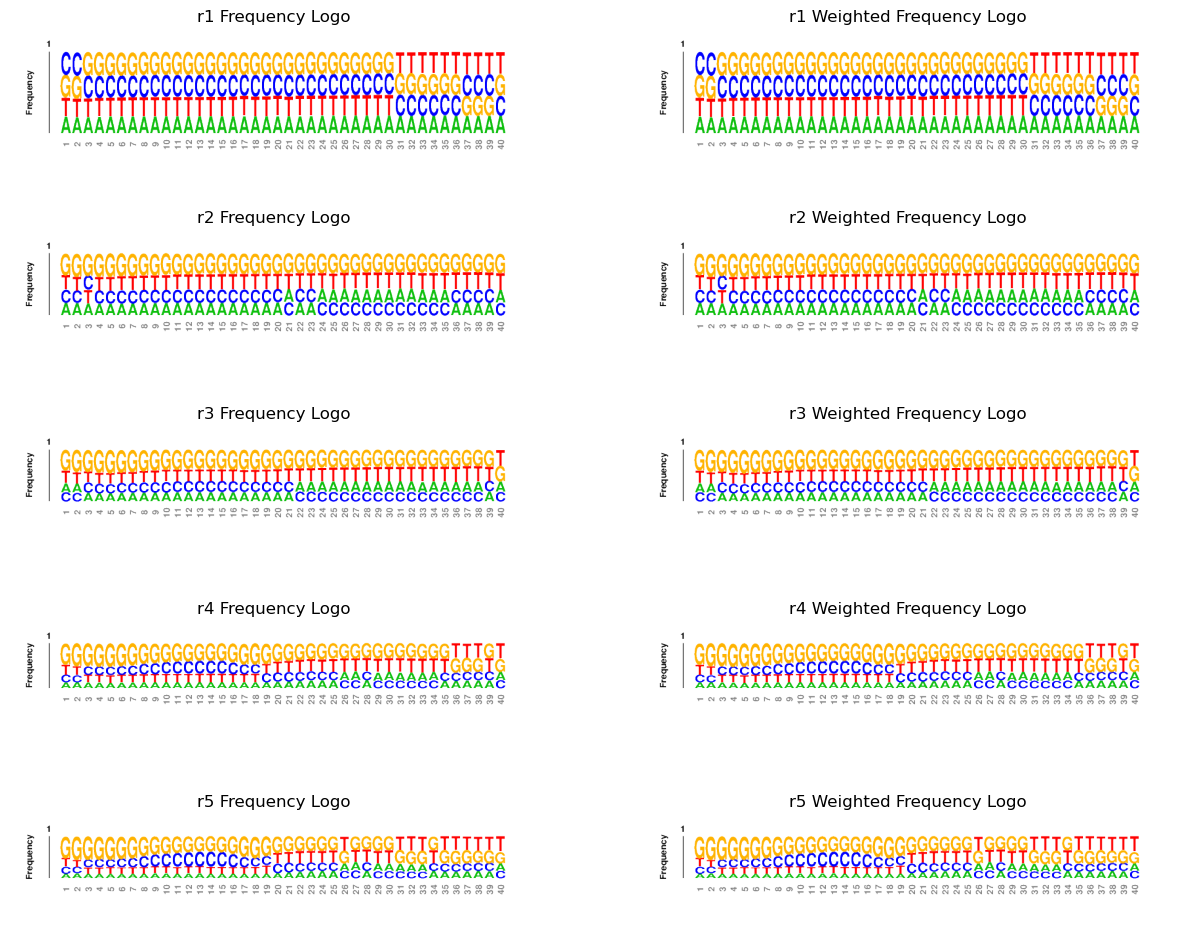

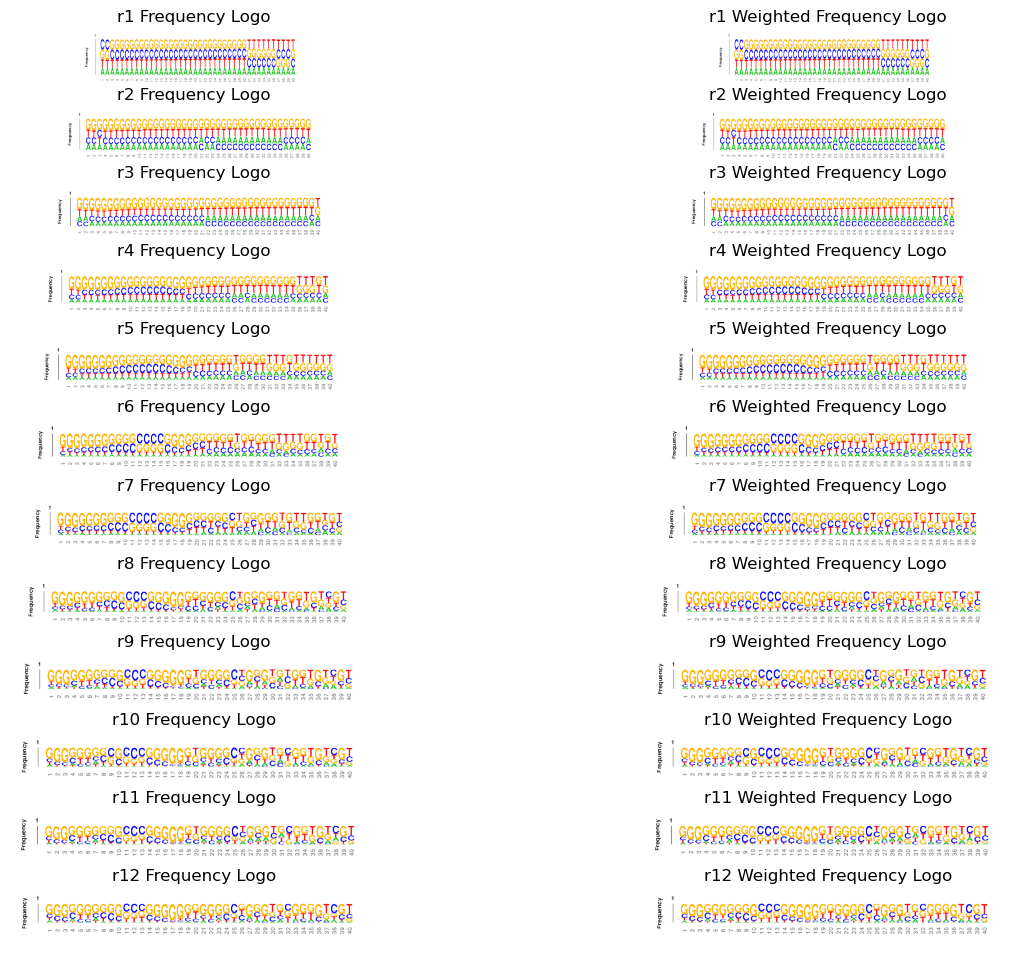

In [7]:
# Seq Logo showing Frequency of Each Amino Acid at each position
fig, axs = plt.subplots(len(rounds), 2)
fig.set_size_inches(15, 12)

for rid, r in enumerate(rounds):
    img1 = mpimg.imread(f"{paths_u[rid]}.freq.png")
    img2 = mpimg.imread(f"{paths_w[rid]}.freq.png")
    axs[rid][0].imshow(img1)
    axs[rid][1].imshow(img2)
    axs[rid][0].axis("off")
    axs[rid][1].axis("off")
    axs[rid][0].set_title(f"{r} Frequency Logo")
    axs[rid][1].set_title(f"{r} Weighted Frequency Logo")

plt.show()

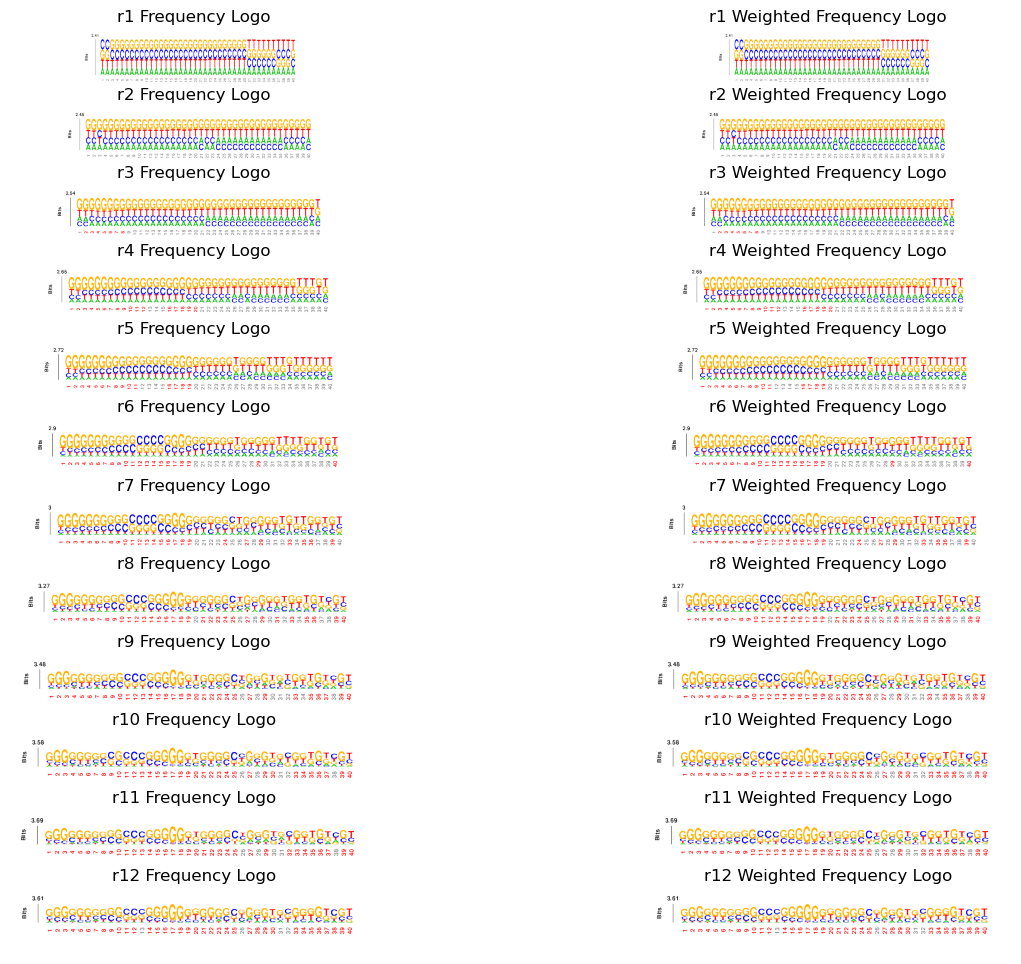

In [8]:
# Seq Logo showing Information of Each Amino Acid at each position
fig, axs = plt.subplots(len(rounds), 2)
fig.set_size_inches(15, 12)

for rid, r in enumerate(rounds):
    img1 = mpimg.imread(f"{paths_u[rid]}.info.png")
    img2 = mpimg.imread(f"{paths_u[rid]}.info.png")
    axs[rid][0].imshow(img1)
    axs[rid][1].imshow(img2)
    axs[rid][0].axis("off")
    axs[rid][1].axis("off")
    axs[rid][0].set_title(f"{r} Frequency Logo")
    axs[rid][1].set_title(f"{r} Weighted Frequency Logo")

plt.show()

In [ ]:
def count_dist(data_w_counts, title):
    fig, axs = plt.subplots(2, 1)
    sns.histplot(data_w_counts, ax=axs[0], x="round", hue="assignment", multiple="fill", palette="rocket", stat="percent")
    sns.histplot(data_w_counts, ax=axs[1], x="round", hue="assignment", multiple="stack", palette="rocket", stat="count")
    # sns.barplot(data=data_w_counts, ax=axs[0], x="round", y="copynum")
    plt.suptitle(title)
    plt.show()

count_dist(all_data, "Unique Sequence Count Distribution")

In [4]:
# Low count == 1, Med count < 10, High count >= 10
# calculate likelihoods from last round rbm only
checkp, v_dir = am.get_checkpoint_path("r12", rbmdir=mdir)
r12_rbm = RBM.load_from_checkpoint(checkp)

# this takes awhile, might be something I optimize further in the future
# am.generate_likelihoods(rounds[1::2], r12_rbm, all_data, "r12_v0")

In [5]:
r12_likelihoods = am.get_likelihoods("./generated/r12_v0.json")

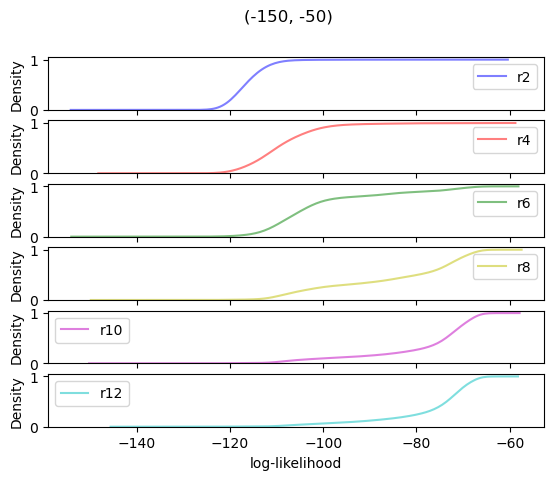

In [6]:
# Plot Likelihoods of Each batch of Data
am.plot_likelihoods(r12_likelihoods["likelihoods"], rounds[1::2], rounds[1::2], xlim=(-150, -50), cdf=True)

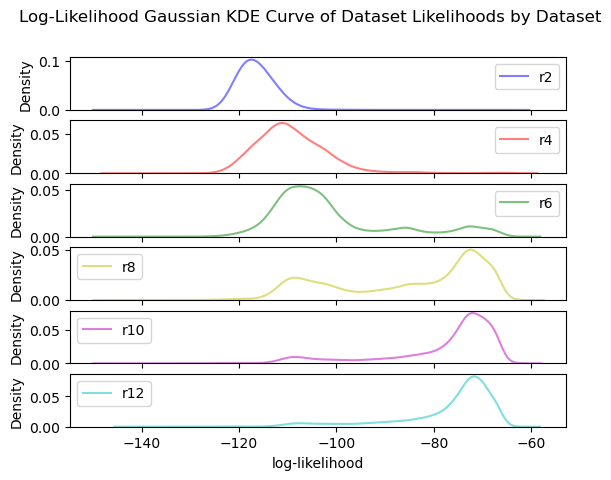

In [8]:
am.plot_likelihoods(r12_likelihoods["likelihoods"], rounds[1::2], rounds[1::2], xlim=(-150, -50), cdf=False)

In [20]:
def shaded_kde_curve(ax, path, xmin, xmax, color):
    vertices = [ (x, y) for x, y in path.vertices if xmin < x < xmax]
    vertices.insert(0, (xmin, 0.))
    vertices.append((xmax, 0.))
    xfill, yfill = zip(*vertices)
    ax.fill(xfill, yfill, color)

def color_subplot(ax, color):
    for spine in ax.spines.values():
        spine.set_edgecolor(color)

def seqlogo_subplot(ax, path, type="info"):
    img = mpimg.imread(f"{path}.{type}.png")
    ax.imshow(img, interpolation="nearest")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.set_xticklabels([])



# bounds listed in ascending order
def multi_peak_seq_log_fig(data, likelihoods, round, bounds, weight=False, title=None, xlim=None):
    data_subsets, seqlogo_paths = [], []
    for iid,  i in enumerate(bounds):
        sub = am.data_subset(data, likelihoods, round, i[0], i[1])
        seqlogo_paths.append(am.seq_logo(sub, f"peak{iid+1}_likeli_{round}", weight=weight, outdir="./generated/"))
        data_subsets.append(sub)

    peak_num = len(bounds)
    gs_kw = dict(width_ratios=[1 for x in range(peak_num)], height_ratios=[1, 1])
    fig, axd = plt.subplot_mosaic([['top' for x in range(peak_num)], [f'lower{x}' for x in range(peak_num)]],
                                  gridspec_kw=gs_kw, figsize=(15, 5), constrained_layout=False)

    axd["top"].set_xlim(*xlim)
    sns.kdeplot(likelihoods[round], ax=axd["top"])

    path = axd["top"].get_children()[0].get_path()

    for iid, i in enumerate(bounds):
         shaded_kde_curve(axd["top"], path, i[0], i[1], am.supported_colors[iid])

    axd["top"].set_xlabel("log-likelihood")
    for iid, i in enumerate(bounds):
        color_subplot(axd[f"lower{iid}"], am.supported_colors[iid])
        seqlogo_subplot(axd[f"lower{iid}"], seqlogo_paths[iid])

    if title is None:
        fig.suptitle(title)
    else:
        fig.suptitle(f"Composition of peaks across RBM Likelihood of Round{round}")

    plt.show()



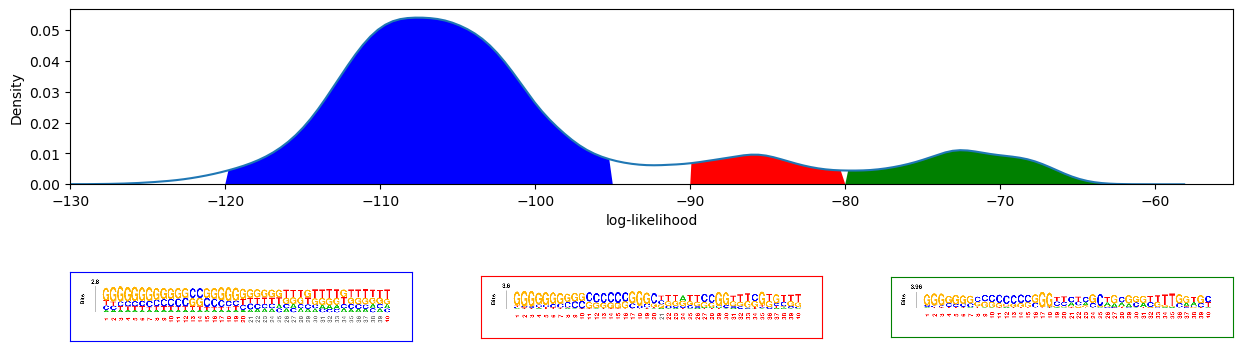

In [21]:
multi_peak_seq_log_fig(all_data, r12_likelihoods["likelihoods"], "r6", [[-120, -95], [-90, -80], [-80, 0]], weight=False, xlim=(-130, -55))

In [5]:
# calculate likelihoods from last round rbm only
checkp, v_dir = am.get_checkpoint_path("r2", rbmdir=mdir)
r2_rbm = RBM.load_from_checkpoint(checkp)

# this takes awhile, might be something I optimize further in the future
# am.generate_likelihoods(rounds[1::2], r2_rbm, all_data, "r2_v0_even_rounds")

In [6]:
r2_likelihoods = am.get_likelihoods("./generated/r2_v0_even_rounds.json")

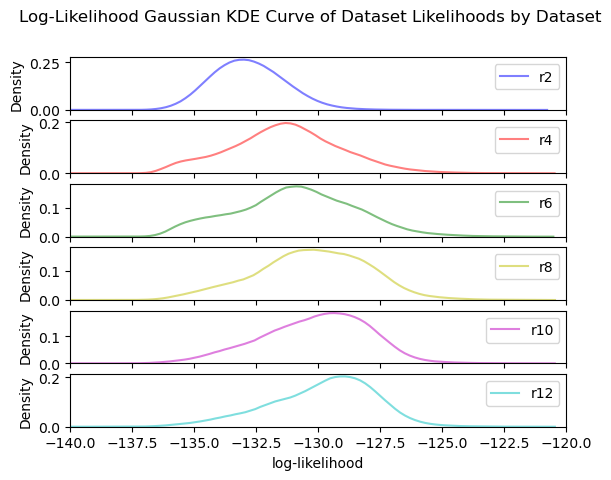

In [13]:
# assign likelihoods in new pd dataframe
am.plot_likelihoods(r2_likelihoods["likelihoods"], rounds[1::2], rounds[1::2], xlim=(-140, -120))

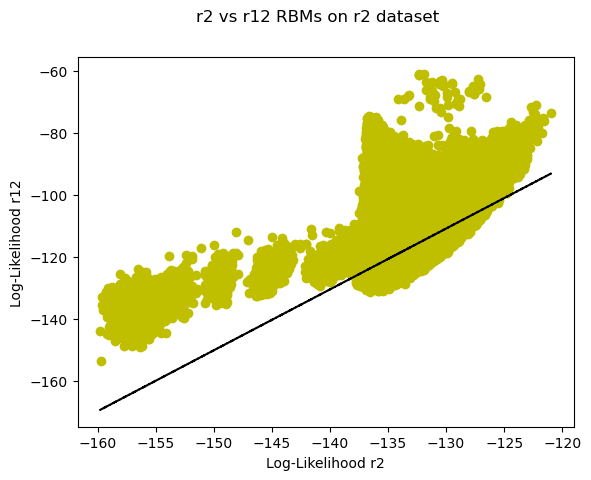

In [16]:
am.compare_likelihood_correlation(r2_likelihoods["likelihoods"]["r2"], r12_likelihoods["likelihoods"]["r2"], "r2 vs r12 RBMs on r2 dataset", ["r2", "r12"])

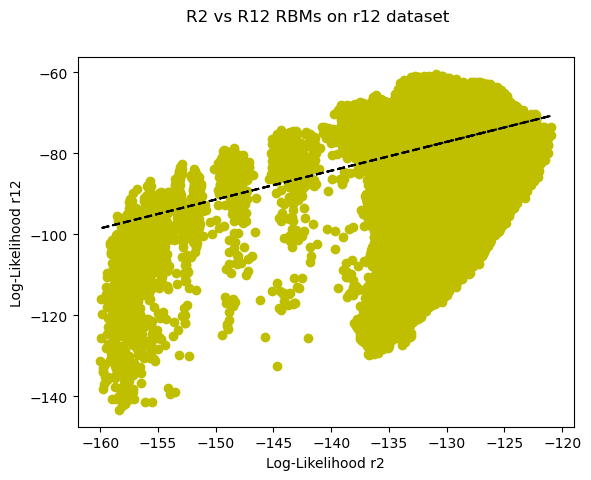

In [18]:
am.compare_likelihood_correlation(r2_likelihoods["likelihoods"]["r12"], r12_likelihoods["likelihoods"]["r12"], "R2 vs R12 RBMs on r12 dataset", ["r2", "r12"])

In [15]:
exp_seqs = {
    "SP5":  'TCAACCATGGTAGGTATTGCTTGGTAGGGATAGTGGGCTT',
    "SP6":  "CAACCCATGGTAGGTATTGCTTGGTAGGGATAGTGGGCTT",
    "SP7":  "CAAAGGAGGGTAGGTAGTGCTTGGTAGGGAAACTCCGCCG",
    "SP6C": 'CAACCCATGGTAGGTATTGCTTGGTAGCGATAGTGGGCTT',
    "SP634": "---CCCATGGTAGGTATTGCTTGGTAGGGATAGTGGG---",
    "SP634G": "---CCCATGGTAGGTATTGGTTGGTAGGGATAGTGGG---",
    "SP634C": "---CCCATGGTAGGTATTGCTTGGTAGCGATAGTGGG---",
    "SP634A": "---CCCATGGTAGGTATTGCATGGTAGGGATAGTGGG---",
    "SP630": "-----CATGGTAGGTATTGCATGGTAGGGATAGTG-----",
    "SP619": "--------------TATTGCATGGTAGGGATAG-------",
}

exp_A_seqs = {
    "SP5":  'TCAACCATGGTAGGTATTGCTTGGTAGGGATAGTGGGCTT',
    "SP6":  "CAACCCATGGTAGGTATTGCTTGGTAGGGATAGTGGGCTT",
    "SP7":  "CAAAGGAGGGTAGGTAGTGCTTGGTAGGGAAACTCCGCCG",
    "SP6C": 'CAACCCATGGTAGGTATTGCTTGGTAGCGATAGTGGGCTT',
    "SP634": "AAACCCATGGTAGGTATTGCTTGGTAGGGATAGTGGGAAA",
    "SP634G": "AAACCCATGGTAGGTATTGGTTGGTAGGGATAGTGGGAAA",
    "SP634C": "AAACCCATGGTAGGTATTGCTTGGTAGCGATAGTGGGAAA",
    "SP634A": "AAACCCATGGTAGGTATTGCATGGTAGGGATAGTGGGAAA",
    "SP630": "AAAAACATGGTAGGTATTGCATGGTAGGGATAGTGAAAAA",
    "SP619": "AAAAAAAAAAAAAATATTGCATGGTAGGGATAGAAAAAAA",
}



exp_set = {'id':list(exp_seqs.keys()), 'sequence':list(exp_seqs.values())}
exp_A_set = {'id':list(exp_A_seqs.keys()), 'sequence':list(exp_A_seqs.values())}
exp_pd = pd.DataFrame(exp_set)
exp_A_pd = pd.DataFrame(exp_A_set)

In [16]:
exp_2_seqs, exp_2_likelis = r2_rbm.predict(exp_pd)
exp_2_A_seqs, exp_2_A_likelis = r2_rbm.predict(exp_A_pd)
exp_12_seqs, exp_12_likelis = r12_rbm.predict(exp_pd)
exp_12_A_seqs, exp_12_A_likelis = r12_rbm.predict(exp_A_pd)

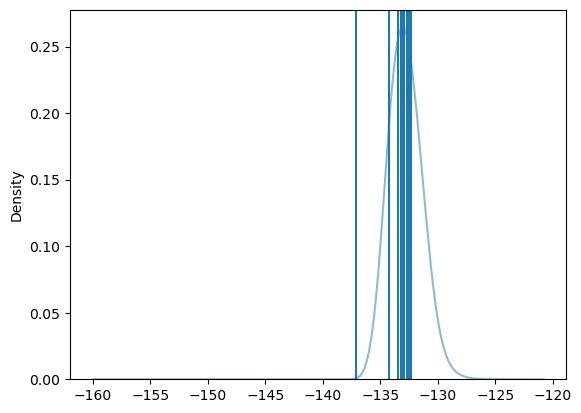

In [17]:
fig, axs = plt.subplots(1, 1)
y = sns.kdeplot(r2_likelihoods["likelihoods"]["r2"], shade=False, alpha=0.5, ax=axs)
for likeli in exp_2_A_likelis:
    plt.axvline(likeli)
plt.show()

In [18]:
for i in range(len(exp_seqs)):
    print(exp_2_A_seqs[i], exp_2_A_likelis[i])

TCAACCATGGTAGGTATTGCTTGGTAGGGATAGTGGGCTT -132.68197807155985
CAACCCATGGTAGGTATTGCTTGGTAGGGATAGTGGGCTT -132.51246189410242
CAAAGGAGGGTAGGTAGTGCTTGGTAGGGAAACTCCGCCG -132.31719745223856
CAACCCATGGTAGGTATTGCTTGGTAGCGATAGTGGGCTT -132.93433717970836
AAACCCATGGTAGGTATTGCTTGGTAGGGATAGTGGGAAA -133.00513372045458
AAACCCATGGTAGGTATTGGTTGGTAGGGATAGTGGGAAA -132.61341545160053
AAACCCATGGTAGGTATTGCTTGGTAGCGATAGTGGGAAA -133.42270537788107
AAACCCATGGTAGGTATTGCATGGTAGGGATAGTGGGAAA -133.18874658196373
AAAAACATGGTAGGTATTGCATGGTAGGGATAGTGAAAAA -134.20747154167958
AAAAAAAAAAAAAATATTGCATGGTAGGGATAGAAAAAAA -137.0695806022038


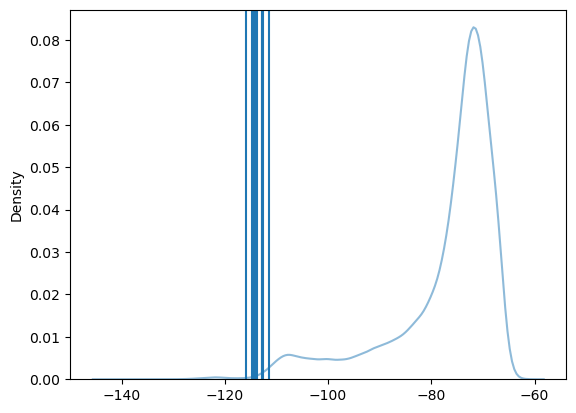

In [19]:
fig, axs = plt.subplots(1, 1)
y = sns.kdeplot(r12_likelihoods["likelihoods"]["r12"], shade=False, alpha=0.5, ax=axs)
for likeli in exp_12_A_likelis:
    plt.axvline(likeli)
plt.show()

In [21]:
for i in range(len(exp_seqs)):
    print(exp_12_A_seqs[i], exp_12_A_likelis[i])

TCAACCATGGTAGGTATTGCTTGGTAGGGATAGTGGGCTT -112.75526198721789
CAACCCATGGTAGGTATTGCTTGGTAGGGATAGTGGGCTT -114.15914836314298
CAAAGGAGGGTAGGTAGTGCTTGGTAGGGAAACTCCGCCG -115.97698502317093
CAACCCATGGTAGGTATTGCTTGGTAGCGATAGTGGGCTT -114.71492920002842
AAACCCATGGTAGGTATTGCTTGGTAGGGATAGTGGGAAA -113.85388701234373
AAACCCATGGTAGGTATTGGTTGGTAGGGATAGTGGGAAA -112.85139824681642
AAACCCATGGTAGGTATTGCTTGGTAGCGATAGTGGGAAA -114.32640912354373
AAACCCATGGTAGGTATTGCATGGTAGGGATAGTGGGAAA -114.27279548960632
AAAAACATGGTAGGTATTGCATGGTAGGGATAGTGAAAAA -112.59060938791754
AAAAAAAAAAAAAATATTGCATGGTAGGGATAGAAAAAAA -111.37298336781086


In [22]:
r12_likelihoods.keys()

dict_keys(['likelihoods', 'sequences'])

In [24]:
lik = r12_likelihoods["likelihoods"]["r12"]
seq = r12_likelihoods["sequences"]["r12"]

for lid, l in enumerate(lik):
    if l > -62:
        print(seq[lid])

GGGGGGCGCCCCCCCCGGTTCTCGCTGCGGGTTTTGGTGC
GGGGCGCCCCCCCCCCGGTTCTCGCTGCGGGTTTTGGTGC
GGGCGCCCCCCCCCCCGGTTCTCGCTGCGGGTTTTGGTGC
GGCCCCCCCCCCCCCCGGTTCTCGCTGCGGGTTTTGGTGC
GGGGGCGCCCCCCCCCGGTTCTCGCTGCGGGTTTTGGTGC
GGGGGGGCCCCCCCCGGGTTCTCGCTGCGGGTTTTGGTGC
GGGGCGGCCCCCCCCCGGTTCTCGCTGCGGGTTTTGGTGC
GGGGGGCCCCCCCCCCGGTTCTCGCTGCGGGTTTTGGTGC
GGGCCGCCCCCCCCCCGGTTCTCGCTGCGGGTTTTGGTGC
GGGGGGGCCGCCCCCCGGTTCTCGCTGCGGGTTTTGGTGC
GGGGGCGCCCCCCCCGGGTTCTCGCTGCGGGTTTTGGTGC
GGGGGGGGGCCCCCCGGGTTCTCGCTGCGGGTTTTGGTGC
GGGGGGGCGCCCCCCCGGTTCTCGCTGCGGGTTTTGGTGC
GGGCGCCCCCCCCCCGGGTTCTCGCTGCGGGTTTTGGTGC
GGGCGGGCCCCCCCCCGGTTCTCGCTGCGGGTTTTGGTGC
GGGGGCGGCCCCCCCCGGTTCTCGCTGCGGGTTTTGGTGC
GGCCGCCCCCCCCCCCGGTTCTCGCTGCGGGTTTTGGTGC
GGGCGGCCCCCCCCCCGGTTCTCGCTGCGGGTTTTGGTGC
GGGCGCGCCCCCCCCCGGTTCTCGCTGCGGGTTTTGGTGC
GGGGGCCCCCCCCCCGGGTTCTCGCTGCGGGTTTTGGTGC
GGGGGCCCCCCCCCCCGGTTCTCGCTGCGGGTTTTGGTGC
GGGGCCCCCCCCCCCGGGTTCTCGCTGCGGGTTTTGGTGC
GGGGGGGGGCCCCCCCGGTTCTCGCTGCGGGTTTTGGTGC
GGGGGGGCGCCCCCCGGGTTCTCGCTGCGGGTTTTGGTGC
GCGCCCCCCCCCCCCC

##Clustering with the r12 RBM

In [33]:
import torch
import rbm_utils

def dataframe_to_input(dataframe, base_to_id, v_num, weights=False):
    seqs = dataframe["sequence"].tolist()
    cat_ten = torch.zeros((len(seqs), v_num), dtype=torch.long)
    for iid, seq in enumerate(seqs):
        for n, base in enumerate(seq):
            cat_ten[iid, n] = base_to_id[base]
    if weights:
        weights = dataframe["copynum"].tolist()
        return cat_ten, weights
    else:
        return cat_ten

def cgf_with_weights_plot(rbm, dataframe, hidden_unit_numbers):
    # Convert Sequences to Integer Format and Compute Hidden Unit Input
    v_num = rbm.v_num
    h_num = rbm.h_num
    molecule = rbm.molecule
    base_to_id = am.int_to_letter_dicts[molecule]
    data_tensor, weights = dataframe_to_input(dataframe, base_to_id, v_num, weights=True)
    rbm.prep_W()
    input_hiddens = rbm.compute_output_v(data_tensor).detach().numpy()

    # Get Beta and sort hidden Units by Frobenius Norms
    beta, W = get_beta_and_W(rbm)
    order = np.argsort(beta)[::-1]

    gs_kw = dict(width_ratios=[3, 1], height_ratios=[1 for x in hidden_unit_numbers])
    grid_names = [[f"weight{i}", f"cgf{i}"] for i in range(len(hidden_unit_numbers))]
    fig, axd = plt.subplot_mosaic(grid_names, gridspec_kw=gs_kw, figsize=(10, 5*len(hidden_unit_numbers)), constrained_layout=True)

    npoints = 1000  # Number of points for graphing CGF curve
    lims = [(np.sum(np.min(w, axis=1)), np.sum(np.max(w, axis=1))) for w in W]  # Get limits for each hidden unit
    fullranges = torch.zeros((npoints, h_num))
    for i in range(h_num):
        x = lims[i]
        fullranges[:, i] = torch.tensor(np.linspace(x[0], x[1], num=npoints).transpose())

    pre_cgf = rbm.cgf_from_inputs_h(fullranges)

    for hid, hu_num in enumerate(hidden_unit_numbers):
        ix = order[hu_num]  # get weight index
        # Make Sequence Logo
        rbm_utils.Sequence_logo(W[ix], ax=axd[f"weight{hid}"], data_type="weights", ylabel=f"Weight #{hu_num}", ticks_every=5, ticks_labels_size=14, title_size=20, molecule=molecule)

        t_x = np.asarray(fullranges[:, ix])
        t_y = np.asarray(pre_cgf[:, ix])
        deltay = np.min(t_y)
        counts, bins = np.histogram(input_hiddens[:, ix], bins=30, weights=weights)
        factor = np.max(t_y) / np.max(counts)
        # WEIGHTS SHOULD HAVE SAME SIZE AS BINS
        axd[f"cgf{hid}"].hist(bins[:-1], bins, color='grey', label='All sequences', weights=counts*factor,
                   histtype='step', lw=3, fill=True, alpha=0.7, edgecolor='black', linewidth=1)
        axd[f"cgf{hid}"].plot(t_x, t_y - deltay, lw=3, color='C1')
        axd[f"cgf{hid}"].set_ylabel('CGF', fontsize=18)
        axd[f"cgf{hid}"].tick_params(axis='both', direction='in', length=6, width=2, colors='k')
        axd[f"cgf{hid}"].tick_params(axis='both', labelsize=16)
        axd[f"cgf{hid}"].yaxis.tick_right()
        axd[f"cgf{hid}"].yaxis.set_label_position("right")
    plt.show()

../rbm_utils.py:436: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks(xticks, xtickslabels)
../rbm_utils.py:436: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks(xticks, xtickslabels)
../rbm_utils.py:436: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks(xticks, xtickslabels)
../rbm_utils.py:436: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks(xticks, xtickslabels)


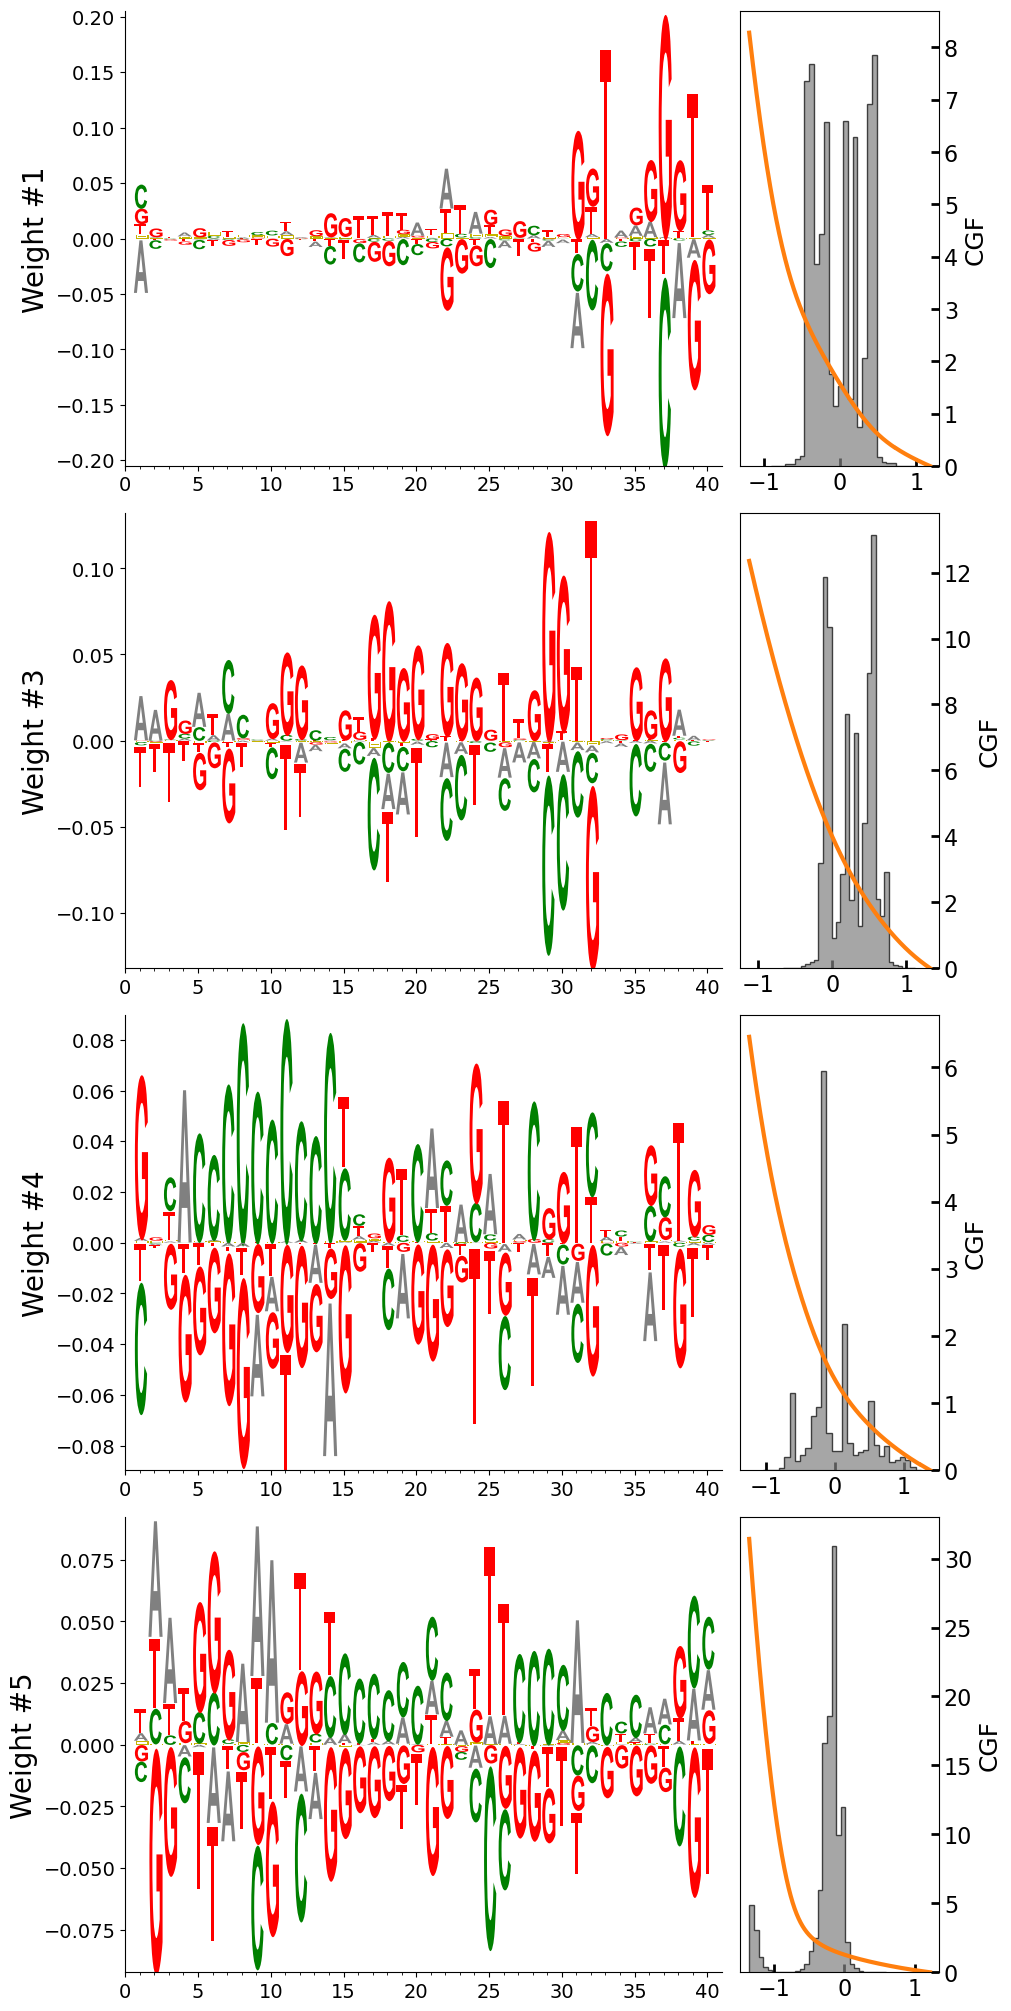

In [34]:
cgf_with_weights_plot(r12_rbm, all_data[all_data["round"] == "r12"], [1, 3, 4, 5])

In [6]:
r12_data = all_data[all_data["round"] == "r12"]
print(r12_data)

                                        sequence  copynum round assignment
0       GGGGGGGTGGGCGCCCGGCCACACCAAAACACGTTCATCT      1.0   r12          L
1       AAGAGGAGGGAGATGGGGGGTGGGTCGGGTATGGGGTCGT      1.0   r12          L
2       GGGTGGGAGGGTGGAGGGTTCTCGTTGCGGGTTTTGGTGC      1.0   r12          L
3       GGGGGGGGGGGGTTCGGGTTGGGGGTCCGCACTATGGCTC     35.0   r12          M
4       TATATATATAAATGGGGGGGGGGGTCGGGTCCGGGGTCCC      1.0   r12          L
...                                          ...      ...   ...        ...
650936  GGGCGGGAGGGAGGGGGGCCACGCCAAAACACGTTCGACT     13.0   r12          M
650937  GCGCCCGCCCCCCCCCGGGGTTGGTCCCGCAGCGGGTGTT      1.0   r12          L
650938  CGGTTTAGCGTCGGGGGGGGGGGCCGGGGTTCGGGGTCGT      1.0   r12          L
650939  GGGGGCGGCCCCCCCCGGCCACACCAAAAAACGTTCAACT      1.0   r12          L
650940  GCGGGGCGGGTTGGGGGGGGGGTTTGGGGTGGGGGGTCCT      1.0   r12          L

[650941 rows x 4 columns]


In [81]:
r12_copynum = r12_data.copynum.tolist()

In [9]:
r12_by_copynum = r12_data.sort_values("copynum", ascending=False)

In [12]:
print(r12_by_copynum.head(1000))

                                        sequence   copynum round assignment
231318  GGGAGGGAGGGTGGGGGGTTCTCGCTGCGGGTTTTGGTGC  780426.0   r12          H
175772  AGGAGGGTAGGTAGTGCTTGGTAGGGAAACTCCGCCGATT  650339.0   r12          H
262991  GGGCGGGAGGGAGGGGGGCCACACCAAAACACGTTCAACT  555261.0   r12          H
345325  TCGCGGGGGGCGGGTCGGGTGCTCGTTCGAGGGGTCGCAG  486834.0   r12          H
137124  AAGGAGGGTAGGTAGTGCTTGGTAGGGAAACTCCGCCGAT  445204.0   r12          H
...                                          ...       ...   ...        ...
249664  GGGAGGGAGGGTGGGGGGTTCGCTGCGGGTTTTGGTGCTG     376.0   r12          H
315157  GGGCGGGAGGGAGGGGGGCCCCACCAAAACACGTTCAACT     375.0   r12          H
428121  AGGCTTATCGCCCGGGGGGTGGGCCCGGGTTCGGGGTCGT     374.0   r12          H
97312   AGGAGGGTAGGTAGTGATTGGTAGGGAAACTCCGCCGATT     374.0   r12          H
572362  AAGGAGGGTAGGTAGCGCTTGGTAGGGAAACTCCGCCGAT     374.0   r12          H

[1000 rows x 4 columns]


In [7]:
import torch

def plot_input_mean(RBM,I, hidden_unit_numbers, I_range=None,weights = None, xlabels = None, figsize = (3,3)):
    if type(hidden_unit_numbers) in [int]:
        hidden_unit_numbers = [hidden_unit_numbers]

    nfeatures = len(hidden_unit_numbers)
    nrows = int(np.ceil(nfeatures/float(2)))

    if I_range is None:
        I_min = I.min()
        I_max = I.max()
        I_range = (I_max-I_min) * torch.arange(0,1+0.01,0.01) + I_min

    mean = RBM.mean_h(torch.repeat_interleave(I_range.unsqueeze(1), RBM.h_num, dim=1))

    gs_kw = dict(width_ratios=[1, 1], height_ratios=[1 for x in range(nrows)])
    grid_names = [[f"{i}_l", f"{i}_r"] for i in range(nrows)]
    fig, axd = plt.subplot_mosaic(grid_names, gridspec_kw=gs_kw, figsize=(2 * figsize[0], nrows*figsize[1]), constrained_layout=True)

    mean = mean.detach().numpy()
    I_range = I_range.detach().numpy()
    I = I.detach().numpy()

    if xlabels is None:
        xlabels = [r'Input $I_{%s}$'%(i) for i in range(nfeatures)]

    row_dict = {0: "_l", 1: "_r"}
    for i in range(nrows): # row number
        for j in range(2): # Column Number
            if not i*2+j < len(hidden_unit_numbers):
                ax = axd[f"{i}{row_dict[j]}"]
                ax.spines['right'].set_visible(False)
                ax.spines['left'].set_visible(False)
                ax.spines['top'].set_visible(False)
                ax.spines['bottom'].set_visible(False)
                ax.set_xticks([])
                ax.set_yticks([])
            else:
                ax = axd[f"{i}{row_dict[j]}"]
                ax2 = ax.twinx()
                ax2.hist(I[:, hidden_unit_numbers[i*2+j]], density=True, weights=weights, bins=100)
                ax.plot(I_range, mean[:, hidden_unit_numbers[i*2+j]], c='black', linewidth=2)
                xmin = np.min(I[:, hidden_unit_numbers[i*2+j]])
                xmax = I[:, hidden_unit_numbers[i*2+j]].max()
                ymin = mean[:, hidden_unit_numbers[i*2+j]].min()
                ymax = mean[:, hidden_unit_numbers[i*2+j]].max()

                ax.set_xlim([xmin, xmax])
                step = int((xmax - xmin) / 4.0) + 1
                xticks = np.arange(int(xmin), int(xmax) + 1, step)
                ax.set_xticks(xticks)
                ax.set_xticklabels(xticks, fontsize=12)
                ax.set_ylim([ymin, ymax])
                step = int((ymax - ymin) / 4.0) + 1
                yticks = np.arange(int(ymin), int(ymax) + 1, step)
                ax.set_yticks(yticks)
                ax.set_yticklabels(yticks, fontsize=12)
                ax2.set_yticks([])
                for tl in ax.get_yticklabels():
                    tl.set_fontsize(14)
                ax.set_zorder(ax2.get_zorder() + 1)
                ax.patch.set_visible(False)
                ax.set_xlabel(xlabels[i*2+j], fontsize=14)

    plt.show()

In [22]:
r12_h_input = r12_rbm.compute_output_v(am.dataframe_to_input(r12_data, am.int_to_letter_dicts[r12_rbm.molecule], r12_rbm.v_num, weights=False))

In [24]:
r12_cat = am.dataframe_to_input(r12_data, am.int_to_letter_dicts[r12_rbm.molecule], r12_rbm.v_num, weights=False)

In [27]:
r12_rbm.prep_W() # Very Necessary
r12_h_input = r12_rbm.compute_output_v(r12_cat)

In [28]:
r12_h_input

tensor([[-0.1407, -0.2153, -0.3924,  ...,  0.0545, -0.2593,  0.1026],
        [ 0.0132, -0.1074, -0.3749,  ...,  0.0324,  0.0989, -0.3012],
        [ 0.0828, -0.2292,  0.4551,  ...,  0.0871,  0.2633,  0.1383],
        ...,
        [ 0.4465, -0.1659, -0.3413,  ...,  0.0847,  0.0859, -0.2462],
        [-0.1595, -0.4493, -0.4500,  ...,  0.0539, -0.3387,  0.4072],
        [ 0.3809, -0.2587,  0.0591,  ...,  0.0552,  0.1333, -0.5721]],
       grad_fn=<SumBackward1>)

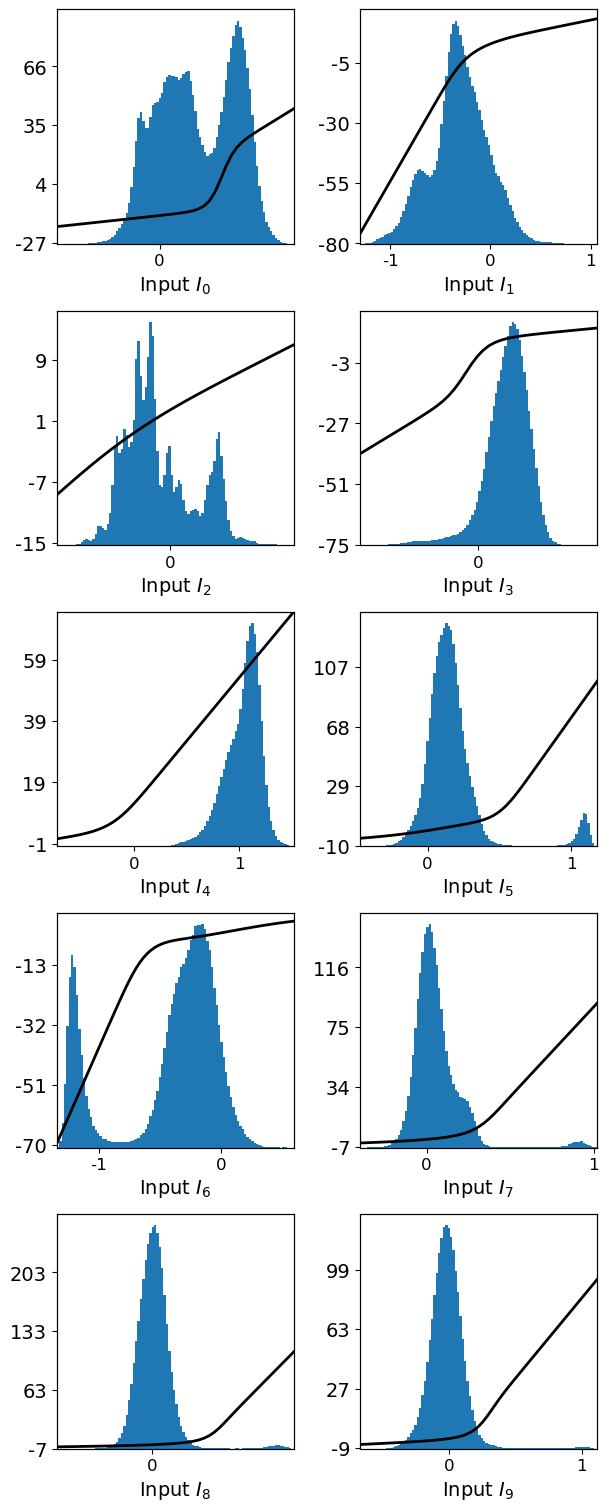

In [38]:
plot_input_mean(r12_rbm, r12_h_input, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]);

In [120]:
def cluster_inputs(I, hidden_unit_2d_combo, padding=0.05, size_to=None, hue_to=None, size_label=None, hue_label=None):

    # mean = RBM.mean_h(torch.repeat_interleave(I_range.unsqueeze(1), RBM.h_num, dim=1))

    [hidden1, hidden2] = hidden_unit_2d_combo

    # mean = mean.detach().numpy()
    # I_range = I_range.detach().numpy()
    I = I.detach().numpy()

    xlab = r'Input $I_{%s}$'%hidden1
    ylab = r'Input $I_{%s}$'%hidden2

    Ih1 = I[:, hidden1]
    Ih2 = I[:, hidden2]

    sns.color_palette("mako", as_cmap=True)
    marker_size = 10
    if size_to is not None and hue_to is None:
        dataset = pd.DataFrame({"input1": Ih1, "input2": Ih2, size_label: size_to})
        g = sns.scatterplot(data=dataset, x="input1", y="input2", size=size_label, alpha=0.7, s=marker_size, palette="mako")
    elif size_to is None and hue_to is not None:
        dataset = pd.DataFrame({"input1": Ih1, "input2": Ih2, hue_label: hue_to})
        g = sns.scatterplot(data=dataset, x="input1", y="input2", hue=hue_label, alpha=0.7, s=marker_size, palette="mako")
    elif size_to is not None and hue_to is not None:
        dataset = pd.DataFrame({"input1": Ih1, "input2": Ih2, size_label: size_to, hue_label: hue_to})
        g = sns.scatterplot(data=dataset, x="input1", y="input2", size=size_label, hue=hue_label, alpha=0.7, s=marker_size, palette="mako")
    else:
        dataset = pd.DataFrame({"input1": Ih1, "input2": Ih2})
        g = sns.scatterplot(data=dataset, x="input1", y="input2", alpha=0.7, s=marker_size, palette="mako")

    # sns.histplot(data_w_counts, ax=axs[1], x="round", hue="assignment", multiple="stack", palette="rocket", stat="count")
    g.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    g.set_xlim([Ih1.min()-padding, Ih1.max()+padding])
    g.set_ylim([Ih2.min()-padding, Ih2.max()+padding])
    g.set_xlabel(xlab)
    g.set_ylabel(ylab)

    # How to make Legend if needed
    # leg = g.axes.flat[0].get_legend()
    # new_title = 'Inputs'
    # leg.set_title(new_title)
    # new_labels = ['label 1', 'label 2']
    # for t, l in zip(leg.texts, new_labels):
    #     t.set_text(l)

    plt.show()

In [47]:
I = r12_h_input.detach().numpy()
in1 = I[:, 0]
in2 = I[:, 6]
dataset = pd.DataFrame({"input1": in1, "input2": in2})
g = sns.scatterplot(data=dataset, x="input1", y="input2")

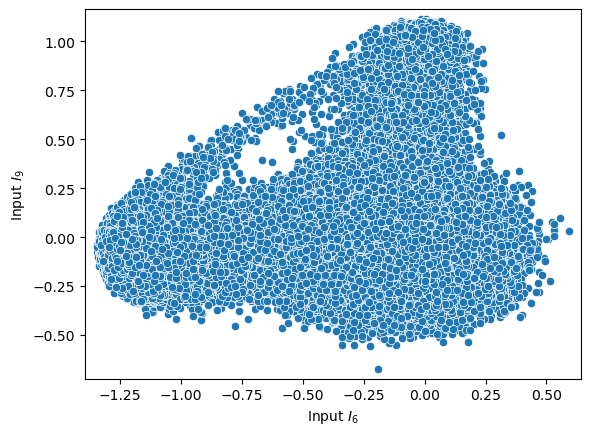

In [73]:
cluster_inputs(r12_h_input, [6, 9], padding=0.05)

In [92]:
r12_likelihoods["likelihoods"]

{'r2': [-121.5203345327262,
  -116.86237052824805,
  -119.48824521214152,
  -110.9294844092276,
  -112.63810464170459,
  -117.15117645979763,
  -122.79637864615503,
  -117.09179931325909,
  -115.75612530982005,
  -120.26661362292495,
  -118.96581719338923,
  -121.49113631363034,
  -117.1023312698214,
  -113.12834335090668,
  -112.71486732140508,
  -118.06131650754492,
  -120.47428532706209,
  -115.6371665971241,
  -114.79344614186078,
  -120.60900088450447,
  -117.83744535831255,
  -116.09586306633781,
  -120.21204984909696,
  -110.62722745355464,
  -110.4771893768251,
  -117.04063019947864,
  -121.3875048562322,
  -115.44836867944667,
  -120.40102877659012,
  -119.11282911402193,
  -115.31501537082778,
  -121.26420545506681,
  -117.72174926330106,
  -119.57272475070525,
  -118.14537313300565,
  -110.21928180684975,
  -117.8027165669435,
  -112.28726585112653,
  -116.87005137684417,
  -110.29408543043044,
  -111.61251385361228,
  -115.48197946049882,
  -121.54818976158725,
  -100.33805

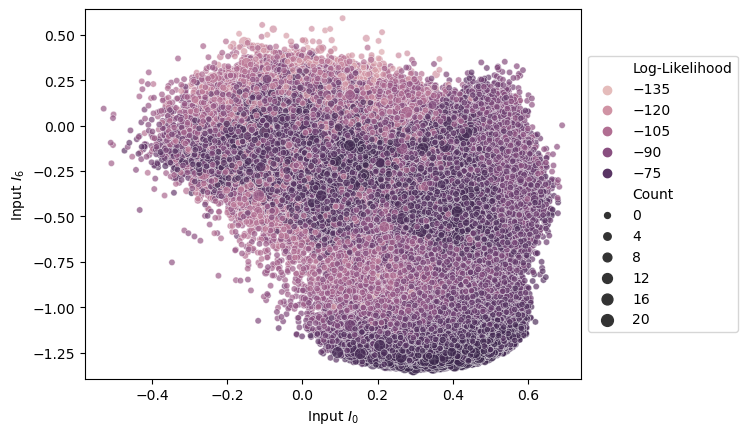

In [110]:
r12_max_cn = [min(x % 500, 20) for x in r12_copynum]
cluster_inputs(r12_h_input, [0, 6], padding=0.05, size_to=r12_max_cn, size_label="Count", hue_to=r12_likelihoods["likelihoods"]["r12"], hue_label="Log-Likelihood")

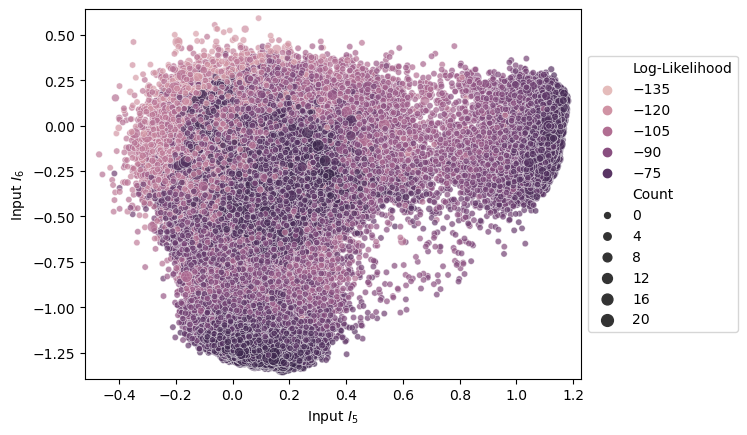

In [119]:
cluster_inputs(r12_h_input, [5, 6], padding=0.05, size_to=r12_max_cn, size_label="Count", hue_to=r12_likelihoods["likelihoods"]["r12"], hue_label="Log-Likelihood")

In [8]:
r12_sub = am.data_subset(all_data, r12_likelihoods["likelihoods"], "r12", -70, 0)

r12_sub_seq = r12_sub.sequence.tolist()
r12_sub_copynum = r12_sub.copynum.tolist()
r12_sub_likelis = r12_sub.likelihood.tolist()

r12_sub_cat = am.dataframe_to_input(r12_sub, am.int_to_letter_dicts[r12_rbm.molecule], r12_rbm.v_num, weights=False)

In [9]:
r12_rbm.prep_W()
r12_sub_input = r12_rbm.compute_output_v(r12_sub_cat)

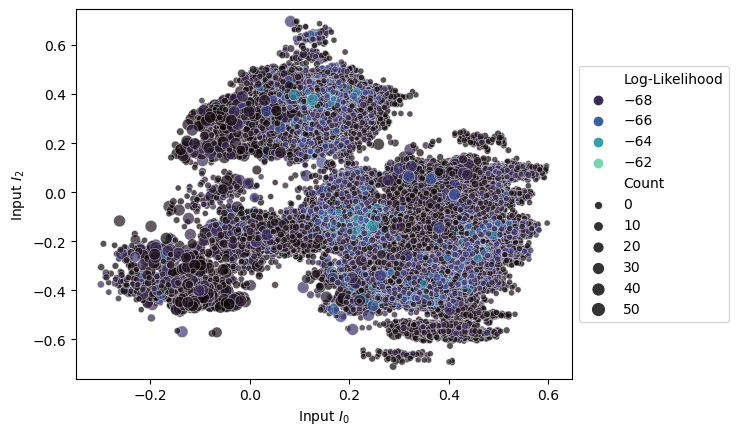

In [121]:
r12_sub_max_cn = [min(x % 500, 50) for x in r12_sub_copynum]
cluster_inputs(r12_sub_input, [0, 2], padding=0.05, size_to=r12_sub_max_cn, size_label="Count", hue_to=r12_sub_likelis, hue_label="Log-Likelihood")

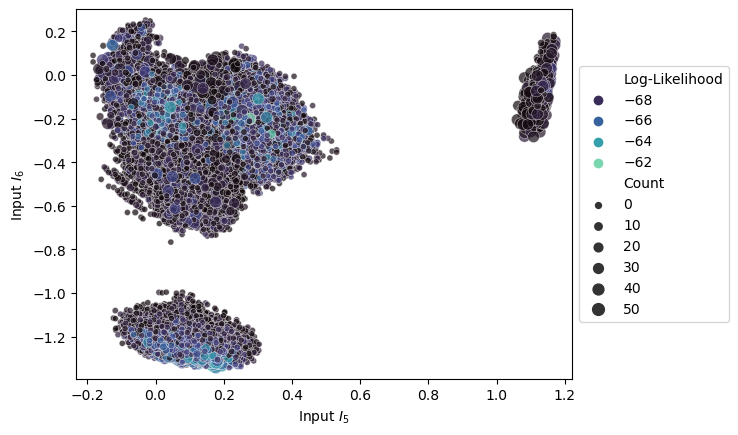

In [122]:
cluster_inputs(r12_sub_input, [5, 6], padding=0.05, size_to=r12_sub_max_cn, size_label="Count", hue_to=r12_sub_likelis, hue_label="Log-Likelihood")

In [ ]:
cluster_inputs(r12_h_input, [0, 1], padding=0.05, size_to=r12_max_cn, size_label="Count", hue_to=r12_likelihoods["likelihoods"]["r12"], hue_label="Log-Likelihood")

In [123]:
r12_h_input.shape

torch.Size([650941, 30])

In [11]:
# Primary Component Analysis
from sklearn.decomposition import PCA
X = r12_h_input.detach().numpy()



NameError: name 'r12_h_input' is not defined

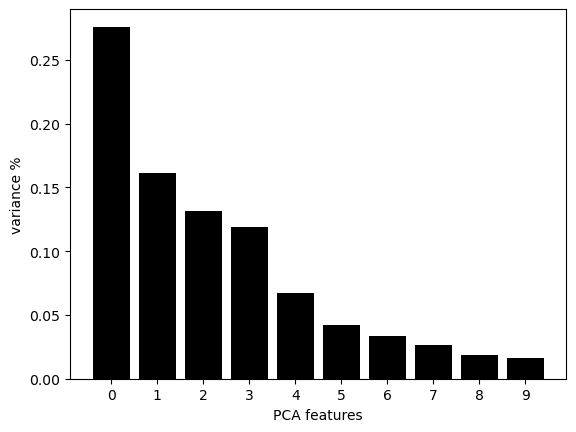

In [141]:
# First PCA pass to decide number of components
# pca = PCA(n_components=10)
# principal_components = pca.fit_transform(X)
# PCA_components = pd.DataFrame(principal_components)

features = range(1, pca.n_components_+1)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
plt.show()

In [10]:
# We will do the first 4 components only, Drop in variance at feature 5
pca_4 = PCA(n_components=4)
principal_components_4 = pca.fit_transform(X)
PCA_components_4 = pd.DataFrame(principal_components)

NameError: name 'PCA' is not defined

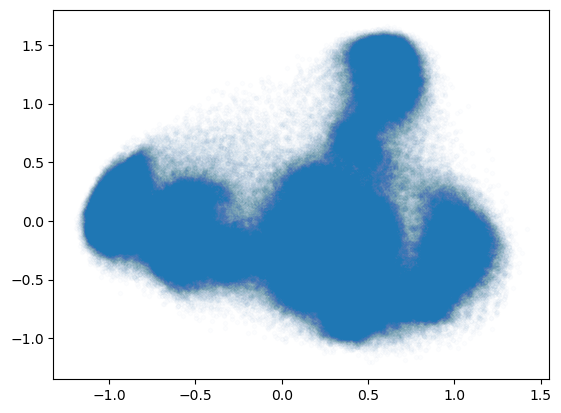

In [146]:
plt.scatter(PCA_components_4[0], PCA_components_4[1], alpha=0.01, marker=".")
plt.show()

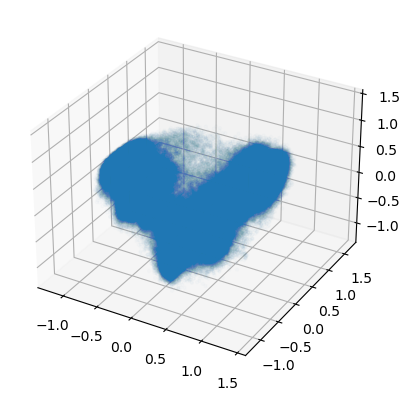

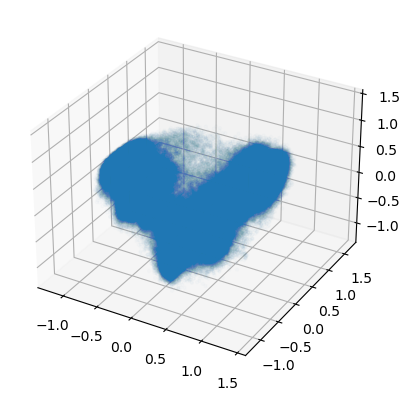

In [139]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(PCA_components[0], PCA_components[1], PCA_components[2], alpha=0.01, marker=".")
plt.show()

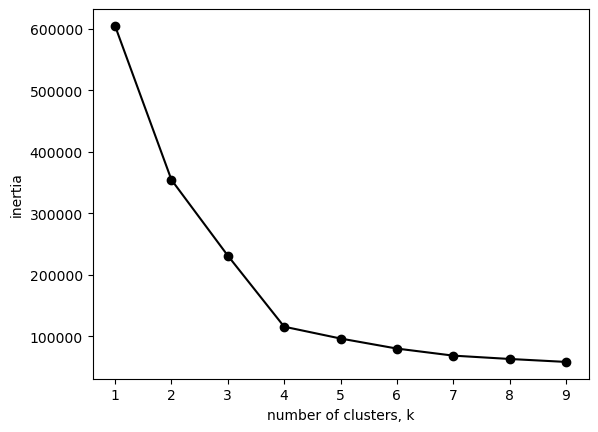

In [147]:
# KMeans on

from sklearn.cluster import KMeans
ks = range(1, 10)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)

    # Fit model to samples
    model.fit(PCA_components_4.iloc[:,:3])

    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)

plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [162]:
# Elbow Point is at 4 so we will run it for 4 clusters
kmeans_pca = KMeans(n_clusters=4, init="k-means++", random_state=38)
kmeans_pca.fit(principal_components_4)
# Add principal components to dataframe
df_pca_kmeans = pd.concat([r12_data.reset_index(drop=True), pd.DataFrame(principal_components_4)], axis=1)
df_pca_kmeans.columns.values[-4:] = ["Component 1", "Component 2", "Component 3", "Component_4"]
# Add labels from kmeans
df_pca_kmeans["K-mean PCA Label"] = kmeans_pca.labels_
# Replace integer with label in new column
df_pca_kmeans["Segment"] = df_pca_kmeans["K-mean PCA Label"].map({0:'first', 1:'second', 2:"third", 3:'fourth'})

In [163]:
sns.scatterplot(data=df_pca_kmeans, x="Component 1", y="Component 2", hue="Segment", alpha=0.1)
plt.show()

/home/jonah/anaconda3/envs/utils/lib/python3.8/site-packages/mpl_toolkits/mplot3d/art3d.py:754: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if zdir == 'x':
/home/jonah/anaconda3/envs/utils/lib/python3.8/site-packages/mpl_toolkits/mplot3d/art3d.py:756: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif zdir == 'y':
/home/jonah/anaconda3/envs/utils/lib/python3.8/site-packages/mpl_toolkits/mplot3d/art3d.py:758: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif zdir[0] == '-':


In [161]:
fig = plt.figure()
ax = plt.axes(projection='3d')
sc = ax.scatter(df_pca_kmeans["Component 1"], df_pca_kmeans["Component 2"], df_pca_kmeans["Component 3"], c=df_pca_kmeans["K-mean PCA Label"], alpha=0.01, marker=".", size=df_pca_kmeans["Component 4"])
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)
plt.show()

<IPython.core.display.Javascript object>

In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d')
sc = ax.scatter(df_pca_kmeans["Component 1"], df_pca_kmeans["Component 2"], df_pca_kmeans["Component 3"], c=df_pca_kmeans["K-mean PCA Label"], alpha=0.01, marker=".")
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)
plt.show()